### Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The drug to study
agents = ["Trastuzumab", "Paclitaxel", "Pertuzumab"]
# Include anything with the agent name
combination_therapy = [True, True, True]
# The gene to examine
gene = "ERBB2"
# cancerTypeDetailed or cancerType
analysis_type = 'cancerType'
# The cancer type
ctype = "Breast Cancer"
# Modifier to the date (how many days earlier the sequencing can be from start of treatment)
modifier = 20
# Modifier to the date (how many days after still counts for death)
modifier_after = 50

In [3]:
config = "../global_config_bash.rc"

Automatically generated

In [4]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [5]:
# Merged ECHO results
# echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# FileA in the manifest directory
# manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')

echo = pd.read_csv("../data/output/output_BB_EchoCaller_Breast_ERBB2/merged/merged.ECHO_results.csv")
manifest = pd.read_csv("../data/input/manifest/BB_EchoCaller_Breast_ERBB2/FileA.tsv", sep = '\t')

In [6]:
progression = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_progression.txt', sep = '\t')
sequencing = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_specimen.txt', sep = '\t')
timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_timeline_follow_up.txt', sep = '\t')
treatment_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_treatment.txt', sep = '\t')

### Setup

ECHO dataframe

In [7]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'oncotreeCode', 'msiScore', 'msiType', 'mutationCount', 'fractionAltered','osStatus', 'osMonths', 'deIDAge', 'stageHighest']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')


per sample

In [8]:
echo = echo[echo[analysis_type] == ctype]

per_sample = pd.DataFrame(echo['tumorSampleId'].unique(), columns = ['sampleId'])
per_sample['amp'] = False
per_sample['ecDNA'] = False
per_sample['patientId'] = ""
per_sample['cn'] = 2

# Dict for indexes in dataframe
per_sample_idx = {}
for i, row in per_sample.iterrows() :
    per_sample_idx[row['sampleId']] = i
    per_sample.loc[i, 'patientId'] = row['sampleId'].split('-')[0] + '-' + row['sampleId'].split('-')[1]

for i, row in echo.iterrows() :
    if row['gene'] == gene :
        per_sample.loc[per_sample_idx[row['tumorSampleId']], 'amp'] = True
        if row['ecDNA_status'] == 'ecDNA' :
            per_sample.loc[per_sample_idx[row['tumorSampleId']], 'ecDNA'] = True
        per_sample.loc[per_sample_idx[row['tumorSampleId']], 'cn'] = row['cn']

# Combined status
per_sample['combined'] = "No ecDNA & No Amp"
for i, row in per_sample.iterrows() :
    if row['ecDNA'] :
        per_sample.loc[i, 'combined'] =  "ecDNA & Amp"       
    elif row['amp'] :
        per_sample.loc[i, 'combined'] =  "No ecDNA & Amp"       

get timeline data

In [9]:
death_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Patient Deceased" :
        death_dict[row['PATIENT_ID']] = row['START_DATE']

In [10]:
last_contact_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']

In [11]:
progression_positive = progression[progression['PROGRESSION'] == 'Yes']

sequencing_dict = {}
for i, row in sequencing.iterrows() :
    sequencing_dict[row['SAMPLE_ID']] = row['START_DATE']

progression_by_patient = {}
for i, row in progression_positive.iterrows() :
    if row['PATIENT_ID'] in progression_by_patient :
        progression_by_patient[row['PATIENT_ID']].append(row['START_DATE'])
    else :
        progression_by_patient[row['PATIENT_ID']] = [row['START_DATE']]

In [12]:
treatment_dict_arr = []
for agent_num, agent in enumerate(agents) :
    treatment_dict = {}
    for i, row in treatment_data.iterrows() :
        if combination_therapy[agent_num] :
            if agent in row['AGENT'] :
                if row['PATIENT_ID'] in treatment_dict :
                    treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
                else :
                    treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]
        else :
            if row['AGENT'] == agent :
                if row['PATIENT_ID'] in treatment_dict :
                    treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
                else :
                    treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]
    treatment_dict_arr.append(treatment_dict)

In [13]:
for agent_num, agent in enumerate(agents) :
    per_sample[f'progressedOrDeceased_{agent}'] = False
    per_sample[f'deceased_{agent}'] = False
    per_sample[f'pfs_{agent}'] = np.nan
    per_sample[f'os_{agent}'] = np.nan
    
    # Iterate all samples
    for i, row in per_sample.iterrows() :
        if row['sampleId'] in sequencing_dict :
            seq_time = sequencing_dict[row['sampleId']]
        
            # Iterate all treatment dates for that sample
            if row['patientId'] in treatment_dict_arr[agent_num] :
                for date_pair in treatment_dict_arr[agent_num][row['patientId']] :
        
                    # If we find a date pair that covers the sequence time
                    if date_pair[0] - modifier < seq_time and (date_pair[1] == np.nan or date_pair[1] > seq_time) :
                        if date_pair[1] == np.nan :
                            end_date = 1000000
                            os_date = 1000000
                        else :
                            end_date = date_pair[1]
                            os_date = date_pair[1]
        
                        # Go through progression dates
                        if row['patientId'] in progression_by_patient :
                            for prog_date in progression_by_patient[row['patientId']] :
                                if prog_date > date_pair[0] and prog_date < date_pair[1] :
                                    per_sample.loc[i, f'progressedOrDeceased_{agent}'] = True
                                    end_date = min(end_date, prog_date)
        
                        # Check if patient has died
                        if row['patientId'] in death_dict :
                            if death_dict[row['patientId']] <= end_date + modifier_after :
                                end_date = min(end_date, death_dict[row['patientId']])
                                per_sample.loc[i, f'progressedOrDeceased_{agent}'] = True
                                per_sample.loc[i, f"deceased_{agent}"] = True
                                os_date = death_dict[row['patientId']]
        
                        # Add last contact possibility
                        if row['patientId'] in last_contact_dict :
                            end_date = min(end_date, last_contact_dict[row['patientId']])
                            os_date = min(os_date, last_contact_dict[row['patientId']])
    
                        if end_date != 1000000 :
                            per_sample.loc[i, f'pfs_{agent}'] = end_date - date_pair[0] 
                        
                        if os_date != 1000000 :
                            per_sample.loc[i, f'os_{agent}'] = os_date - date_pair[0] 
        else :
            print(f"{row['sampleId']} Sequencing Date Not Found")

P-0000358-T01-IM3 Sequencing Date Not Found
P-0033620-T01-IM6 Sequencing Date Not Found
P-0000358-T01-IM3 Sequencing Date Not Found
P-0033620-T01-IM6 Sequencing Date Not Found
P-0000358-T01-IM3 Sequencing Date Not Found
P-0033620-T01-IM6 Sequencing Date Not Found


### Results

Progression Free

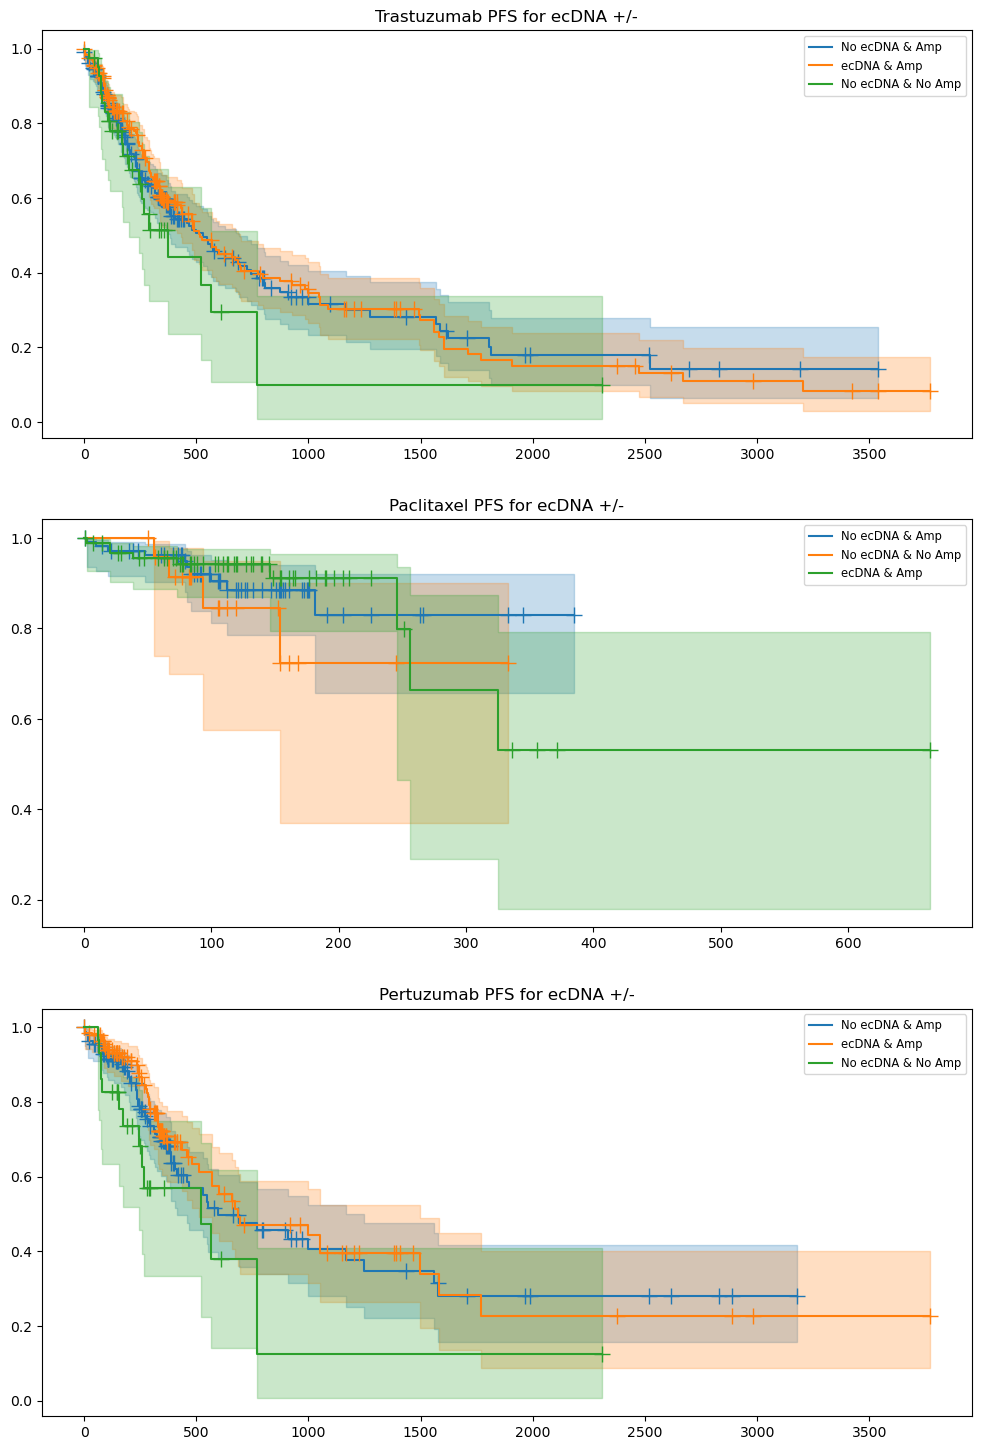

In [14]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(len(agents), 1, figsize = (12, 6 * len(agents)))
axs = axs.flatten()

for agent_num, agent in enumerate(agents) :
    per_sample_for_km = per_sample.dropna(subset = [f"pfs_{agent}"])
    
    kmf = KaplanMeierFitter()
    for status in per_sample_for_km['combined'].unique():
        subset = per_sample_for_km[per_sample_for_km['combined'] == status]
        kmf.fit(subset[f'pfs_{agent}'], event_observed=(subset[f'progressedOrDeceased_{agent}'] == True))
        # labels
        kmf.plot(show_censors=True, ci_show=True, label=f'{status}', ax = axs[agent_num])

    axs[agent_num].legend(loc='upper right', fontsize='small')

    axs[agent_num].set_title(f'{agent} PFS for ecDNA +/-')
    axs[agent_num].set_xlabel("")
    

In [15]:
from itertools import combinations
from lifelines.statistics import logrank_test
from IPython.display import display


for agent in agents :
    per_sample_for_km = per_sample.dropna(subset = [f"pfs_{agent}"])

    kmf = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    
    statuses = per_sample_for_km['combined'].unique()
    pairwise_tests = {}
    
    for group1, group2 in combinations(statuses, 2) :
        group1_data = per_sample_for_km[per_sample_for_km['combined'] == group1]
        group2_data = per_sample_for_km[per_sample_for_km['combined'] == group2]
    
        # Fit KM curves
        kmf.fit(group1_data[f'pfs_{agent}'], event_observed=(group1_data['combined'] == 1))
        kmf2.fit(group2_data[f'pfs_{agent}'], event_observed=(group2_data['combined'] == 1))
        
        # Perform log-rank test
        result = logrank_test(group1_data[f'pfs_{agent}'], group2_data[f'pfs_{agent}'], event_observed_A=(group1_data[f'progressedOrDeceased_{agent}'] == True), event_observed_B=(group2_data[f'progressedOrDeceased_{agent}'] == True))
        
        # Store p-value in dictionary
        pairwise_tests[(group1, group2)] = result.p_value
    
    p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
    for (group1, group2), p_value in pairwise_tests.items():
        if group1 != group2:
            p_values_matrix.loc[group1, group2] = p_value
    p_values_matrix = p_values_matrix.fillna("")
    
    print(f"{agent} P-values for PFS KM Curves")
    
    styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
        'selector': 'th',
        'props': [('border', '1px solid black')]
    }, {
        'selector': 'td',
        'props': [('border', '1px solid black')]
    }])
    display(styled_matrix)

Trastuzumab P-values for PFS KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.743827,0.211298
ecDNA & Amp,,0.104105


Paclitaxel P-values for PFS KM Curves


,No ecDNA & No Amp,ecDNA & Amp
No ecDNA & Amp,0.322582,0.942927
No ecDNA & No Amp,,0.311743


Pertuzumab P-values for PFS KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.554526,0.080134
ecDNA & Amp,,0.025263


Overall Survival

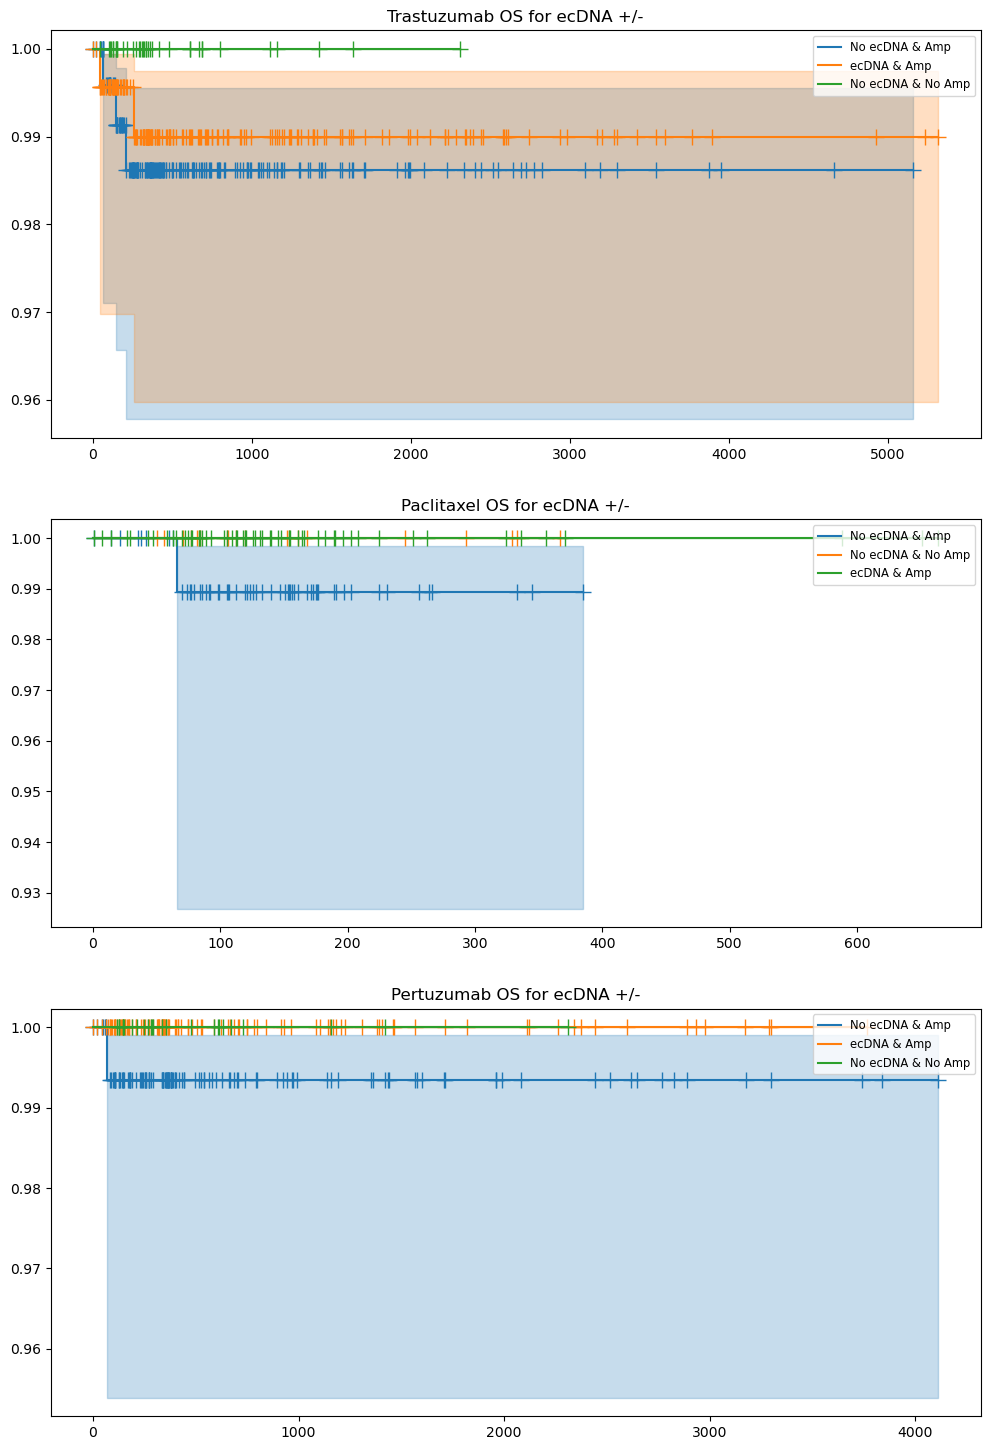

In [16]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(len(agents), 1, figsize = (12, 6 * len(agents)))
axs = axs.flatten()

for agent_num, agent in enumerate(agents) :
    per_sample_for_km = per_sample.dropna(subset = [f"os_{agent}"])
    
    kmf = KaplanMeierFitter()
    for status in per_sample_for_km['combined'].unique():
        subset = per_sample_for_km[per_sample_for_km['combined'] == status]
        kmf.fit(subset[f'os_{agent}'], event_observed=(subset[f'deceased_{agent}'] == True))
        # labels
        kmf.plot(show_censors=True, ci_show=True, label=f'{status}', ax = axs[agent_num])

    axs[agent_num].legend(loc='upper right', fontsize='small')

    axs[agent_num].set_title(f'{agent} OS for ecDNA +/-')
    axs[agent_num].set_xlabel("")
    

In [17]:
from itertools import combinations
from lifelines.statistics import logrank_test

for agent in agents :
    kmf = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()

    per_sample_for_os_km = per_sample.dropna(subset = [f"os_{agent}"])

    statuses = per_sample_for_os_km['combined'].unique()
    pairwise_tests = {}
    
    for group1, group2 in combinations(statuses, 2) :
        group1_data = per_sample_for_os_km[per_sample_for_os_km['combined'] == group1]
        group2_data = per_sample_for_os_km[per_sample_for_os_km['combined'] == group2]
    
        # Fit KM curves
        kmf.fit(group1_data[f'os_{agent}'], event_observed=(group1_data['combined'] == 1))
        kmf2.fit(group2_data[f'os_{agent}'], event_observed=(group2_data['combined'] == 1))
        
        # Perform log-rank test
        result = logrank_test(group1_data[f'os_{agent}'], group2_data[f'os_{agent}'], event_observed_A=(group1_data[f'deceased_{agent}'] == True), event_observed_B=(group2_data[f'deceased_{agent}'] == True))
        
        # Store p-value in dictionary
        pairwise_tests[(group1, group2)] = result.p_value
    
    p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
    for (group1, group2), p_value in pairwise_tests.items():
        if group1 != group2:
            p_values_matrix.loc[group1, group2] = p_value
    p_values_matrix = p_values_matrix.fillna("")
    
    print(f"{agent} P-values for OS KM Curves")
    
    styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
        'selector': 'th',
        'props': [('border', '1px solid black')]
    }, {
        'selector': 'td',
        'props': [('border', '1px solid black')]
    }])
    display(styled_matrix)

Trastuzumab P-values for OS KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.721241,0.493806
ecDNA & Amp,,0.564914


Paclitaxel P-values for OS KM Curves


,No ecDNA & No Amp,ecDNA & Amp
No ecDNA & Amp,0.620846,0.350308
No ecDNA & No Amp,,1.000000


Pertuzumab P-values for OS KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.353479,0.661213
ecDNA & Amp,,1.000000


### Other Statistics

Progression Free

In [18]:
cox_dfs = []
cox_agents = []
for agent_num, agent in enumerate(agents) :
    specific_cox_df = pd.DataFrame(columns = ['atype', 'p_value', 'hazardRatio', 'upper', 'lower'])

    gene_cox = per_sample_for_km.dropna(subset = [f'pfs_{agent}', f'progressedOrDeceased_{agent}', 'ecDNA', 'amp'])
    gene_cox[f'progressedOrDeceased_{agent}'] = gene_cox[f'progressedOrDeceased_{agent}'].astype(int)
    from lifelines import CoxPHFitter

    # Just ecDNA +/-
    cox = CoxPHFitter()
    covariates = [f'pfs_{agent}', f'progressedOrDeceased_{agent}', 'ecDNA']
    try :
        cox.fit(gene_cox[covariates], duration_col = f'pfs_{agent}', event_col = f'progressedOrDeceased_{agent}')
        new_row = {
            'atype' : "ecDNA Status",
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
            'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
            'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
        }
        new_df = pd.DataFrame([new_row])
        specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)
    except :
        print(f"{agent} Has Too Few Points")

    # ecDNA plus echo amplification status
    cox = CoxPHFitter()
    covariates = [f'pfs_{agent}', f'progressedOrDeceased_{agent}', 'amp', 'ecDNA']
    try :
        cox.fit(gene_cox[covariates], duration_col = f'pfs_{agent}', event_col = f'progressedOrDeceased_{agent}')
        new_row = {
            'atype' : "ecDNA Status + ECHO Amp",
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
            'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
            'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
        }
    
        new_df = pd.DataFrame([new_row])
        specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)
    except :
        print(f"{agent} Has Too Few Points")
    # ecDNA plus copy number
    cox = CoxPHFitter()
    covariates = [f'pfs_{agent}', f'progressedOrDeceased_{agent}', 'cn', 'ecDNA']
    try :
        cox.fit(gene_cox[covariates], duration_col = f'pfs_{agent}', event_col = f'progressedOrDeceased_{agent}')
        new_row = {
            'atype' : "ecDNA Status + Copy Number",
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
            'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
            'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
        }
        new_df = pd.DataFrame([new_row])
        
        specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)
    except :
        print(f"{agent} Has Too Few Points")

    if len(specific_cox_df) :
        cox_dfs.append(specific_cox_df)
        cox_agents.append(agent)

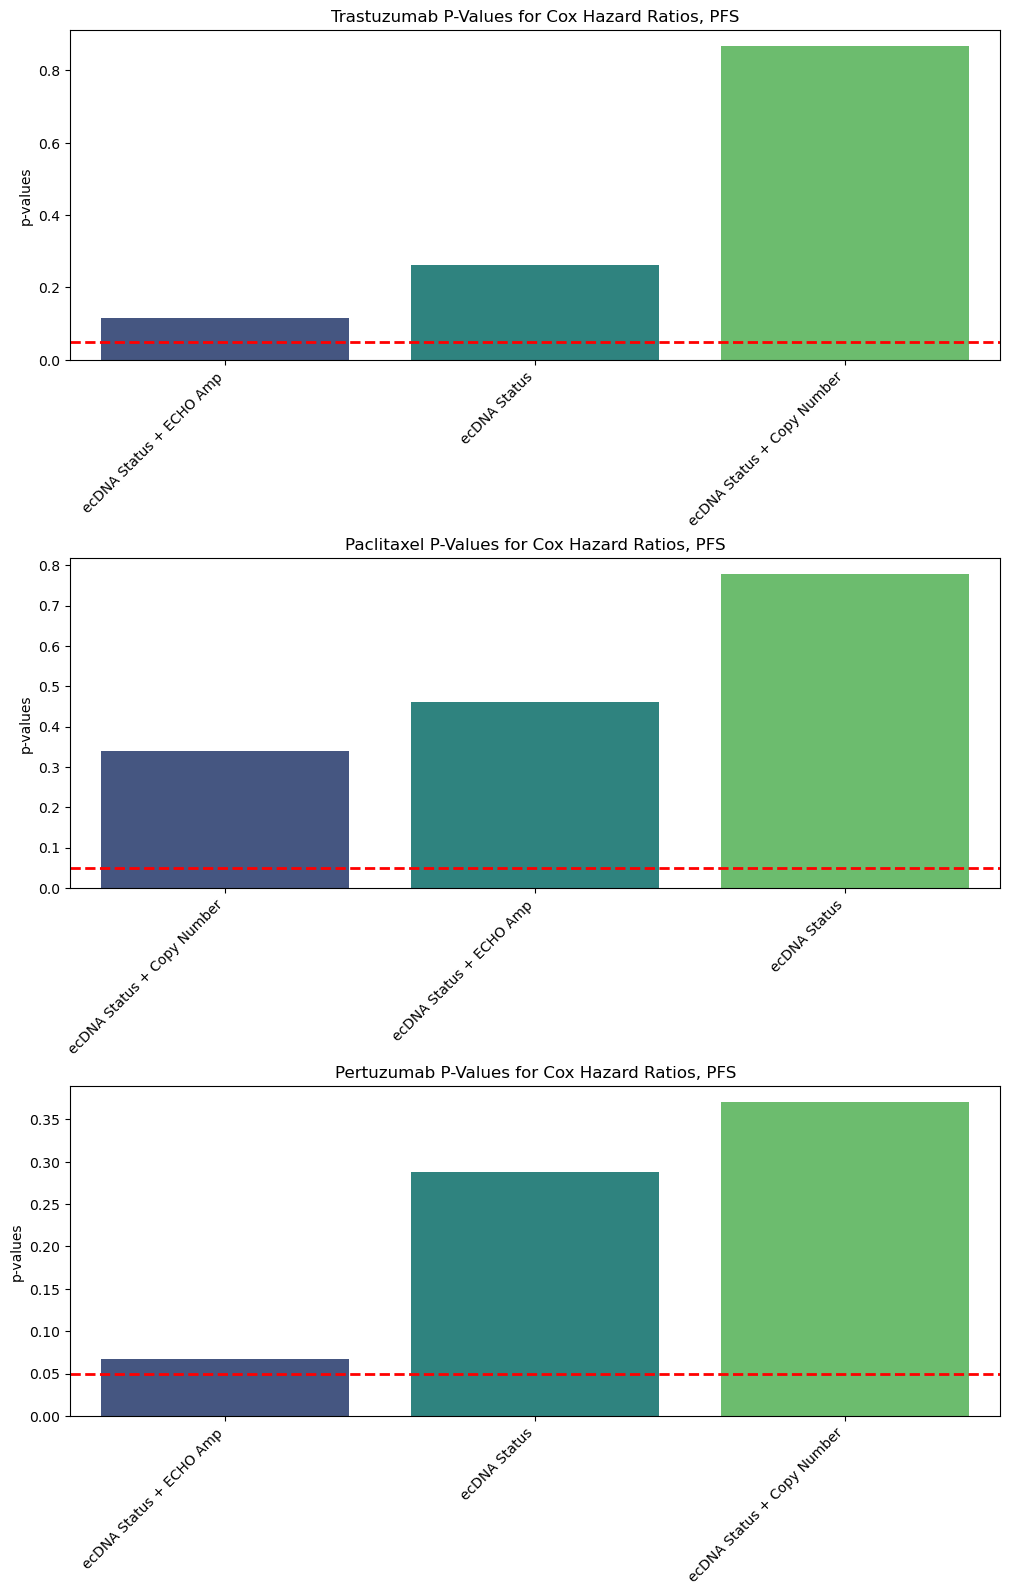

In [19]:
import seaborn as sns

fig, axs = plt.subplots(len(cox_dfs), 1, figsize = (12, 6 * len(agents)))
axs = axs.flatten()
for agent_num in range(len(cox_dfs)) :
    agent = cox_agents[agent_num]
    cox_dfs[agent_num] = cox_dfs[agent_num].sort_values(by='p_value')
    bars = sns.barplot(x='atype', y='p_value', data=cox_dfs[agent_num], palette='viridis', ax=axs[agent_num])
    axs[agent_num].set_ylabel('p-values')
    axs[agent_num].set_xlabel("")
    bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
    axs[agent_num].axhline(y=0.05, color='r', linestyle='--', linewidth=2)
    axs[agent_num].set_title(f"{agent} P-Values for Cox Hazard Ratios, PFS")

plt.subplots_adjust(wspace=0.5, hspace=0.6)


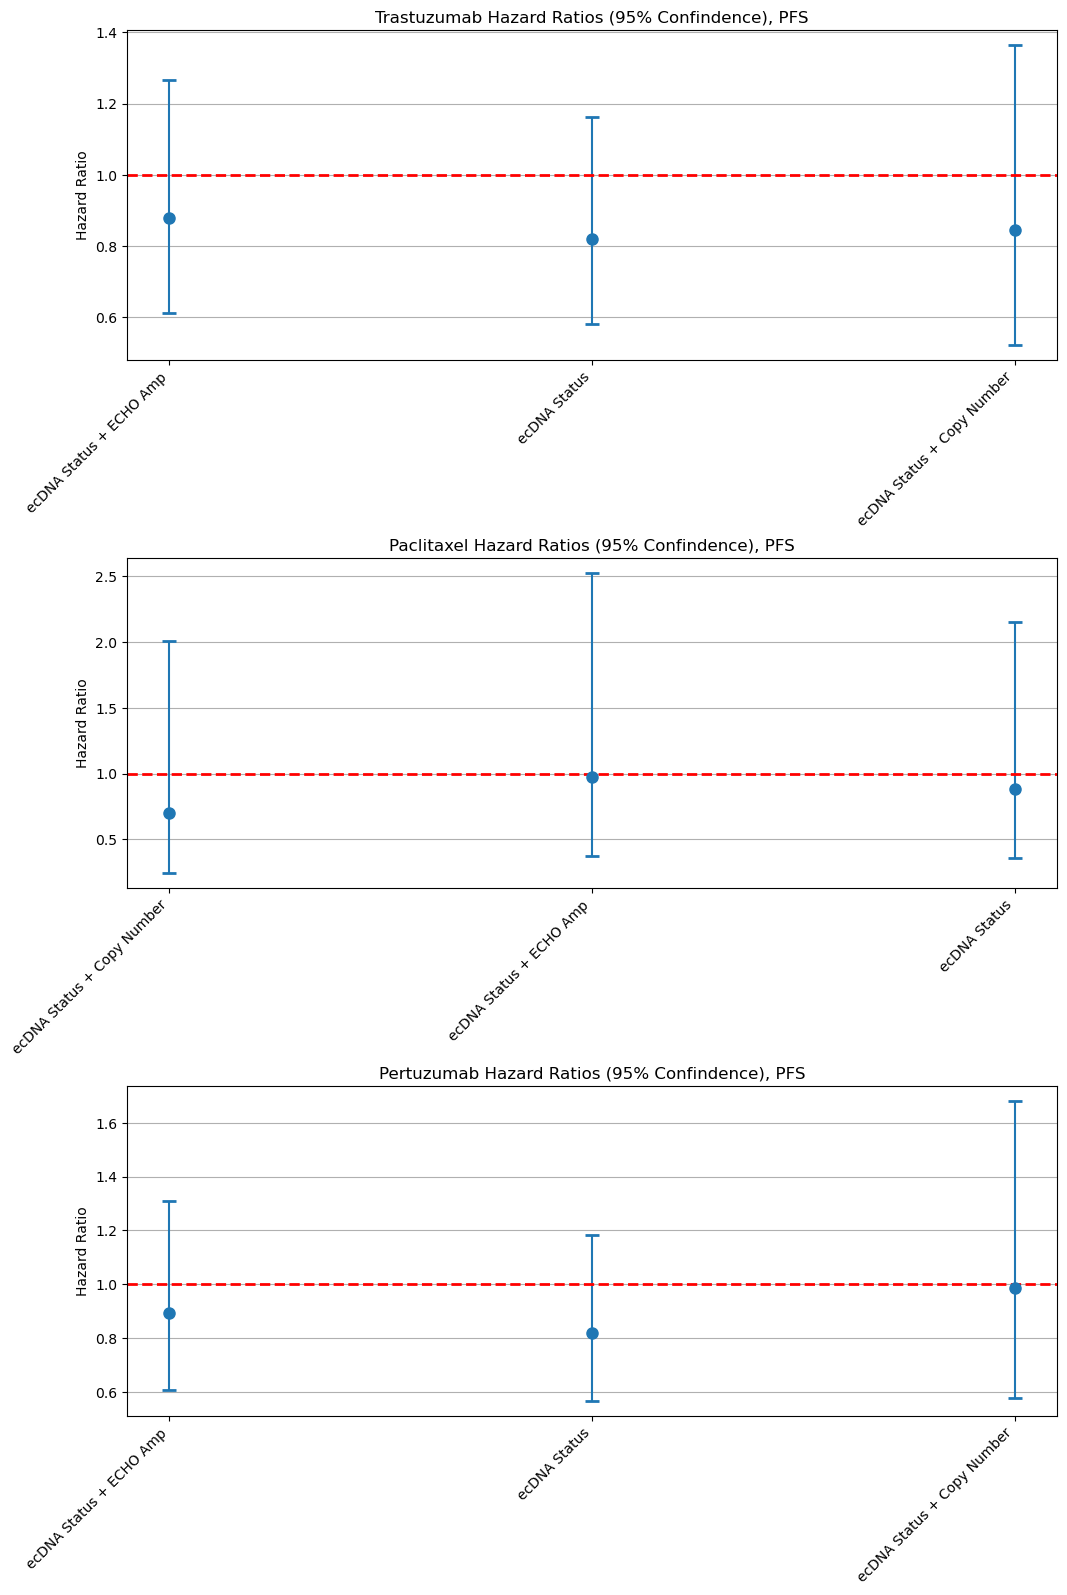

In [20]:

fig, axs = plt.subplots(len(cox_dfs), 1, figsize = (12, 6 * len(agents)))
axs = axs.flatten()

for agent_num in range(len(cox_dfs)) :
    agent = cox_agents[agent_num]
    non_zero = cox_dfs[agent_num][cox_dfs[agent_num]['lower'] != 0]
    
    # Number of rows in the DataFrame
    num_rows = non_zero.shape[0]
        
    # Plot points
    positions = np.arange(num_rows)
    axs[agent_num].errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
                 fmt='o', markersize=8, capsize=5, capthick=2)
    
    # Set x-axis ticks and labels
    axs[agent_num].set_xlabel('')
    axs[agent_num].set_xticks(positions, non_zero['atype'],rotation=45, ha='right')
    
    
    # Add labels and title
    axs[agent_num].set_ylabel('Hazard Ratio')
    axs[agent_num].set_title(f'{agent} Hazard Ratios (95% Confindence), PFS')
    axs[agent_num].axhline(y=1, color='r', linestyle='--', linewidth=2)
    
    axs[agent_num].grid(True, axis='y')  # Add grid lines for better visualization
plt.subplots_adjust(wspace=0.5, hspace=0.6)


Overall Survival

In [21]:
cox_dfs = []
cox_agents = []
for agent_num, agent in enumerate(agents) :
    specific_cox_df = pd.DataFrame(columns = ['atype', 'p_value', 'hazardRatio', 'upper', 'lower'])

    gene_cox = per_sample_for_km.dropna(subset = [f'os_{agent}', f'deceased_{agent}', 'ecDNA', 'amp'])
    gene_cox[f'deceased_{agent}'] = gene_cox[f'deceased_{agent}'].astype(int)
    from lifelines import CoxPHFitter

    # Just ecDNA +/-
    cox = CoxPHFitter()
    covariates = [f'os_{agent}', f'deceased_{agent}', 'ecDNA']

    try :
        cox.fit(gene_cox[covariates], duration_col = f'os_{agent}', event_col = f'deceased_{agent}')
        new_row = {
            'atype' : "ecDNA Status",
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
            'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
            'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
        }
        new_df = pd.DataFrame([new_row])
        specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)
    
    except :
        print(f"{agent} Has Too Few Points")
        
    # ecDNA plus echo amplification status
    cox = CoxPHFitter()
    covariates = [f'os_{agent}', f'deceased_{agent}', 'amp', 'ecDNA']
    try :
        cox.fit(gene_cox[covariates], duration_col = f'os_{agent}', event_col = f'deceased_{agent}')
        new_row = {
            'atype' : "ecDNA Status + ECHO Amp",
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
            'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
            'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
        }
    
        new_df = pd.DataFrame([new_row])
        specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)
        
    except :
        print(f"{agent} Has Too Few Points")
        
    # ecDNA plus copy number
    cox = CoxPHFitter()
    covariates = [f'os_{agent}', f'deceased_{agent}', 'cn', 'ecDNA']
    try :
        cox.fit(gene_cox[covariates], duration_col = f'os_{agent}', event_col = f'deceased_{agent}')
        new_row = {
            'atype' : "ecDNA Status + Copy Number",
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)']['ecDNA'],
            'upper' : cox.summary['exp(coef) upper 95%']['ecDNA'],
            'lower' : cox.summary['exp(coef) lower 95%']['ecDNA']
        }
        new_df = pd.DataFrame([new_row])
        specific_cox_df = pd.concat([specific_cox_df, new_df], ignore_index = True)

    except :
        print(f"{agent} Has Too Few Points")
    if len(specific_cox_df) :
        cox_dfs.append(specific_cox_df)
        cox_agents.append(agent)

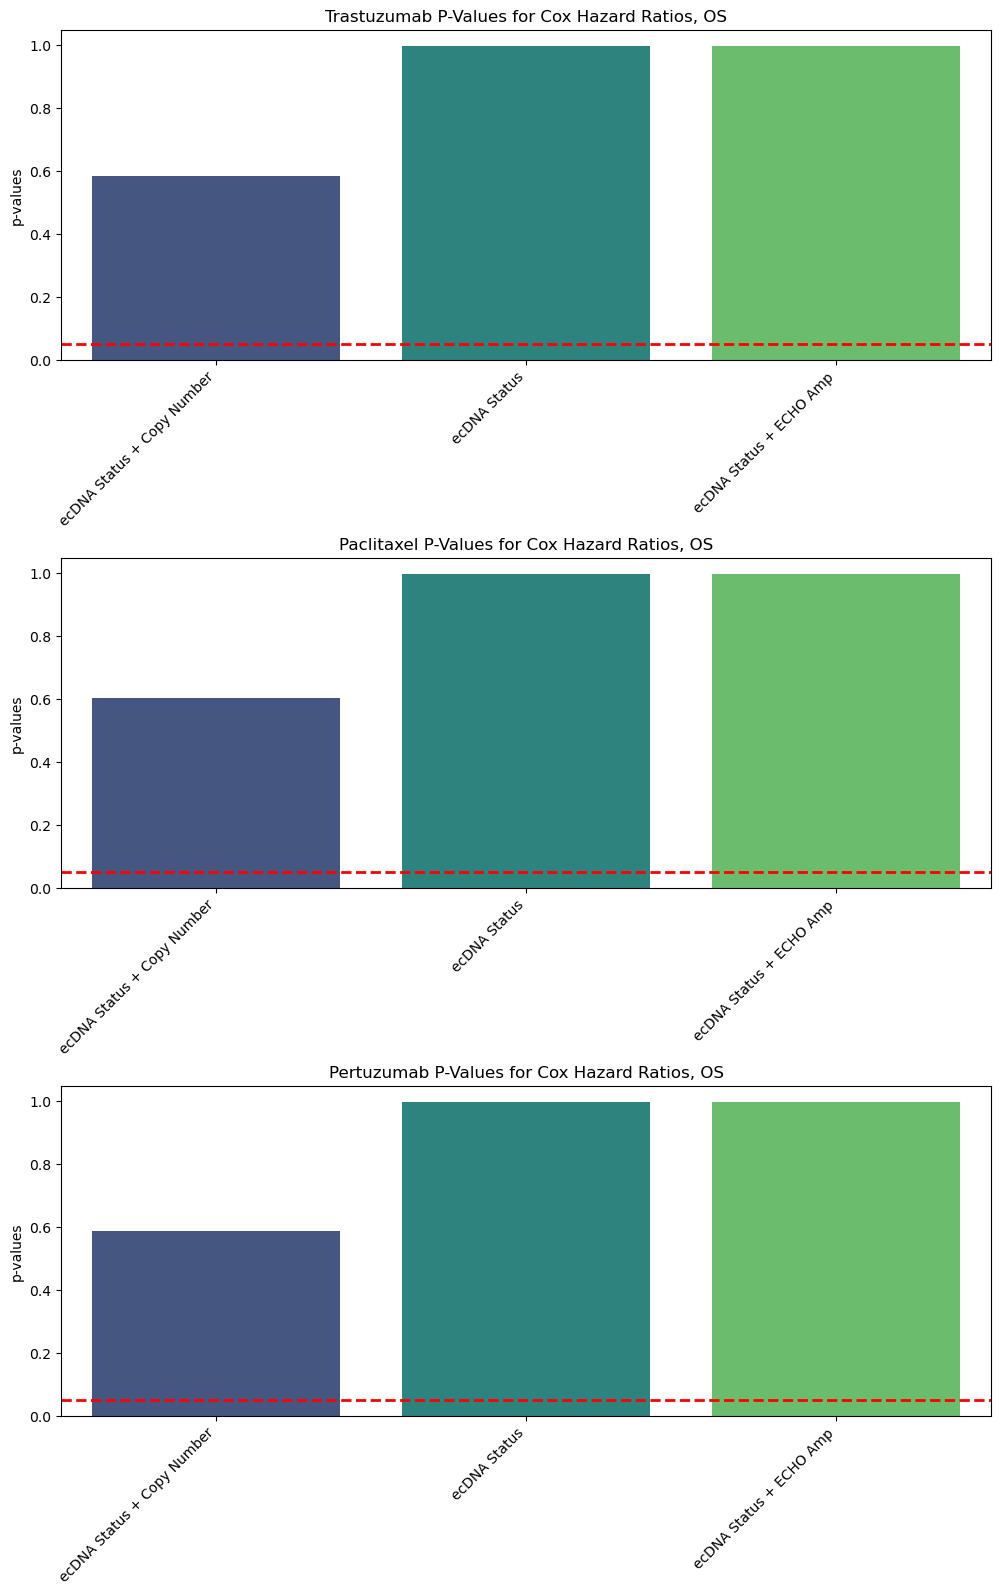

In [22]:
import seaborn as sns

fig, axs = plt.subplots(len(cox_dfs), 1, figsize = (12, 6 * len(agents)))
axs = axs.flatten()
for agent_num in range(len(cox_dfs)) :
    agent = cox_agents[agent_num]
    cox_dfs[agent_num] = cox_dfs[agent_num].sort_values(by='p_value')
    bars = sns.barplot(x='atype', y='p_value', data=cox_dfs[agent_num], palette='viridis', ax=axs[agent_num])
    axs[agent_num].set_ylabel('p-values')
    axs[agent_num].set_xlabel("")
    bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
    axs[agent_num].axhline(y=0.05, color='r', linestyle='--', linewidth=2)
    axs[agent_num].set_title(f"{agent} P-Values for Cox Hazard Ratios, OS")

plt.subplots_adjust(wspace=0.5, hspace=0.6)


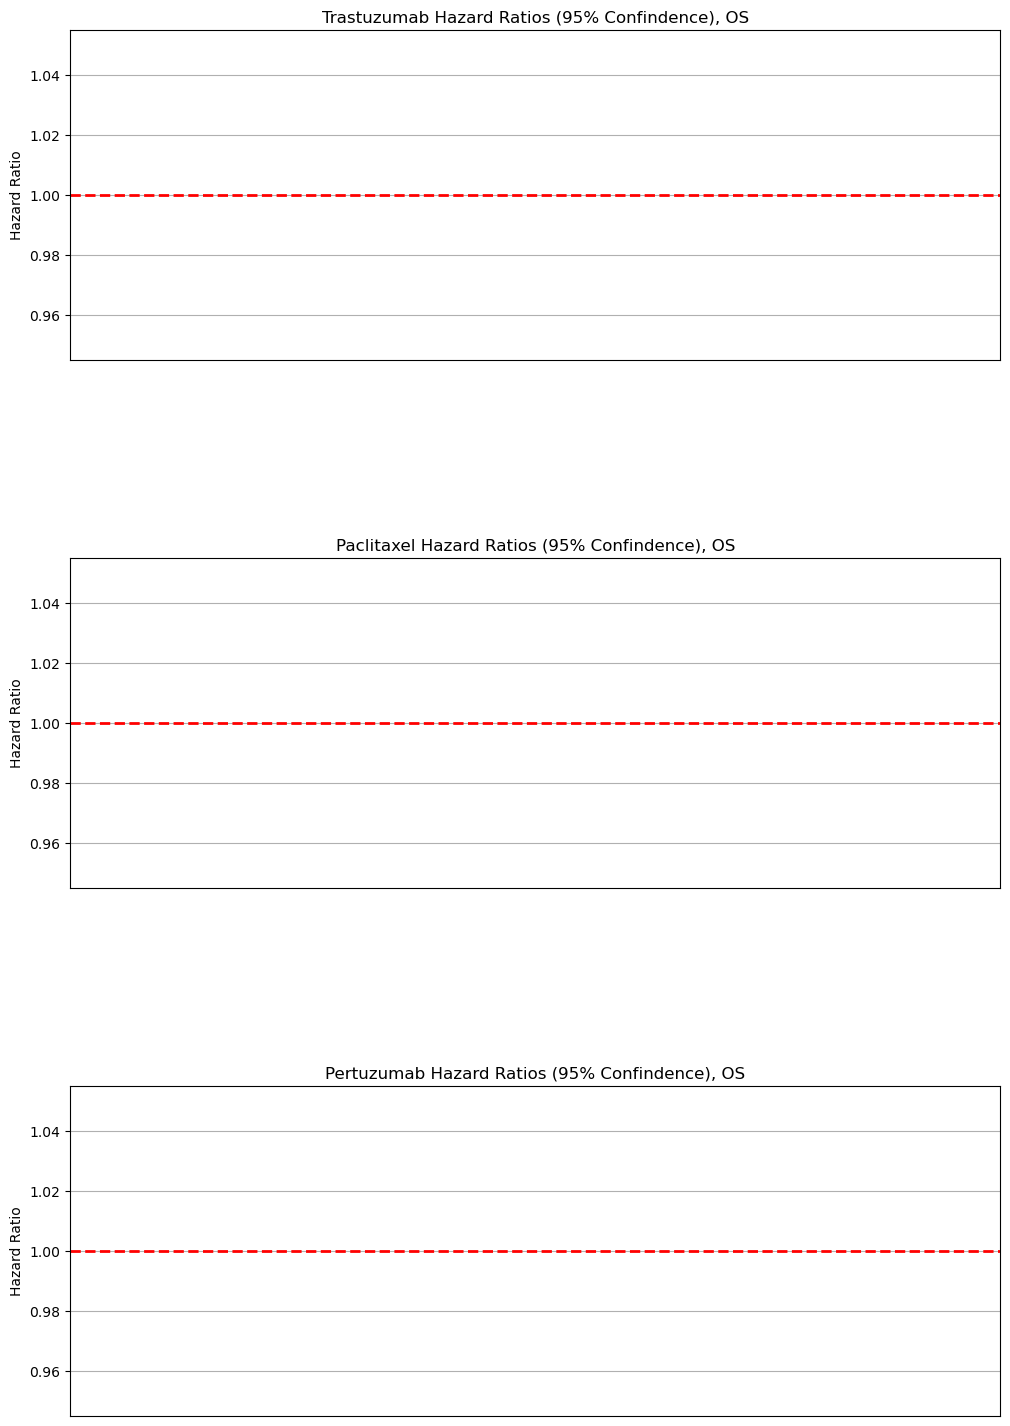

In [23]:

fig, axs = plt.subplots(len(cox_dfs), 1, figsize = (12, 6 * len(agents)))
axs = axs.flatten()

for agent_num in range(len(cox_dfs)) :
    agent = cox_agents[agent_num]
    non_zero = cox_dfs[agent_num][cox_dfs[agent_num]['lower'] != 0]
    
    # Number of rows in the DataFrame
    num_rows = non_zero.shape[0]
        
    # Plot points
    positions = np.arange(num_rows)
    axs[agent_num].errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
                 fmt='o', markersize=8, capsize=5, capthick=2)
    
    # Set x-axis ticks and labels
    axs[agent_num].set_xlabel('')
    axs[agent_num].set_xticks(positions, non_zero['atype'],rotation=45, ha='right')
    
    
    # Add labels and title
    axs[agent_num].set_ylabel('Hazard Ratio')
    axs[agent_num].set_title(f'{agent} Hazard Ratios (95% Confindence), OS')
    axs[agent_num].axhline(y=1, color='r', linestyle='--', linewidth=2)
    
    axs[agent_num].grid(True, axis='y')  # Add grid lines for better visualization
plt.subplots_adjust(wspace=0.5, hspace=0.6)
